In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/dsKal100

/content/drive/MyDrive/Github/dsKal100


In [3]:
!ls
%cd hw/hw02
!ls

 cs-231n-python-colab.ipynb   lec
 disc			      other
 grad_proj		      proj
 hw			     'python-tutorial for cs231n Stanford.ipynb'
 lab			      README.md
/content/drive/MyDrive/Github/dsKal100/hw/hw02
data  data.zip	ds100_utils.py	hw02.ipynb  pics  __pycache__  tests


# Homework 2: Food Safety
## Cleaning and Exploring Data with Pandas
## Due Date: Thursday Feb 3rd, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*


## This Assignment

In this homework, we will investigate restaurant food safety scores for restaurants in San Francisco. The scores and violation information have been [made available by the San Francisco Department of Public Health](https://data.sfgov.org/Health-and-Social-Services/Restaurant-Scores-LIVES-Standard/pyih-qa8i). The main goal for this assignment is to walk through the process of Data Cleaning and EDA.


As we clean and explore these data, you will gain practice with:
* Reading simple csv files and using Pandas
* Working with data at different levels of granularity
* Identifying the type of data collected, missing values, anomalies, etc.
* Exploring characteristics and distributions of individual variables

## Score Breakdown
Question | Points
--- | ---
1a | 1
1b | 2
1c | 1
2a | 2
2b | 2
2ci | 1
2cii | 1
2d | 2
2e | 2
2f | 2
3a | 1
3bi | 2
3ci | 1
3cii | 1
3ciii | 1
3civ | 1
3d | 3
4a | 2
4b | 3
4c | 2
5a|1
5b|2
6a|3
6b|2
6c|2
7|0
Total | 43

## Before You Start

For each question in the assignment, please write down your answer in the answer cell(s) right below the question.

We understand that it is helpful to have extra cells breaking down the process towards reaching your final answer. If you happen to create new cells below your answer to run codes, **NEVER** add cells between a question cell and the answer cell below it. It will cause errors when we run the autograder, and it will sometimes cause a failure to generate the PDF file.

**Important note: The local autograder tests will not be comprehensive. You can pass the automated tests in your notebook but still fail tests in the autograder.** Please be sure to check your results carefully.

Finally, unless we state otherwise, **do not use for loops or list comprehensions**. The majority of this assignment can be done using builtin commands in Pandas and numpy.  Our autograder isn't smart enough to check, but you're depriving yourself of key learning objectives if you write loops / comprehensions, and you also won't be read for the midterm.


In [4]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

import zipfile
from pathlib import Path

import os
import plotly

from IPython.display import display, Image
def display_figure_for_grader(fig):
    plotly.io.write_image(fig, 'temp.png')
    display(Image('temp.png'))

## Obtaining the Data

### File Systems and I/O



In general, we will focus on using python commands to investigate files.  However, it can sometimes be easier to use shell commands in your local operating system.  The following cells demonstrate how to do this.

In [5]:
## data.zip was already in my folder??
from pathlib import Path
data_dir = Path('.')
data_dir.mkdir(exist_ok = True)
file_path = data_dir / Path('data.zip')
dest_path = file_path

In [7]:
dest_path

PosixPath('data.zip')

After running the cell above, if you list the contents of the directory containing this notebook, you should see `data.zip`.

*Note*: The command below starts with an `!`. This tells our Jupyter notebook to pass this command to the operating system. In this case, the command is the `ls` Unix command which lists files in the current directory.

In [6]:
!ls

data  data.zip	ds100_utils.py	hw02.ipynb  pics  __pycache__  tests


## 1: Loading Food Safety Data

We have data, but we don't have any specific questions about the data yet. Let's focus on understanding the structure of the data; this involves answering questions such as:

* Is the data in a standard format or encoding?
* Is the data organized in records?
* What are the fields in each record?

Let's start by looking at the contents of `data.zip`. It's not just a single file but rather a compressed directory of multiple files. We could inspect it by uncompressing it using a shell command such as `!unzip data.zip`, but in this homework we're going to do almost everything in Python for maximum portability.

## Looking Inside and Extracting the Zip Files

The following codeblocks are setup. Simply run the cells; **do not modify them**. Question 1a is where you will start to write code.

Here, we assign `my_zip` to a `zipfile.Zipfile` object representing `data.zip`, and assign `list_names` to a list of all the names of the contents in `data.zip`.

In [8]:
my_zip = zipfile.ZipFile(dest_path, 'r')
list_names = my_zip.namelist()
list_names

['data/',
 'data/bus.csv',
 'data/ins.csv',
 'data/ins2vio.csv',
 'data/vio.csv',
 'data/sf_zipcodes.json',
 'data/legend.csv']

You may notice that we did not write `zipfile.ZipFile('data.zip', ...)`. Instead, we used `zipfile.ZipFile(dest_path, ...)`. In general, we **strongly suggest having your filenames hard coded as string literals only once** in a notebook. It is very dangerous to hard code things twice because if you change one but forget to change the other, you can end up with bugs that are very hard to find.

Now we display the files' names and their sizes.

In [9]:
my_zip = zipfile.ZipFile(dest_path, 'r')
for info in my_zip.infolist():
    print('{}\t{}'.format(info.filename, info.file_size))

data/	0
data/bus.csv	665365
data/ins.csv	1860919
data/ins2vio.csv	1032799
data/vio.csv	4213
data/sf_zipcodes.json	474
data/legend.csv	120


Often when working with zipped data, we'll never unzip the actual zipfile. This saves space on our local computer. However, for this homework the files are small, so we're just going to unzip everything. This has the added benefit that you can look inside the csv files using a text editor, which might be handy for understanding the structure of the files. The cell below will unzip the csv files into a subdirectory called `data`.

In [10]:
data_dir = Path('.')
my_zip.extractall(data_dir)
!ls {data_dir / Path("data")}

bus.csv      ins.csv	 legend.csv	   vio.csv
ins2vio.csv  ins.gsheet  sf_zipcodes.json


The cell above created a folder called `data`, and in it there should be five CSV files. Let's open up `legend.csv` to see its contents. To do this, click on the jupyterhub logo on the top left, then navigate to `su21/hw/hw3/data/` and click on `legend.csv`. The file will open up in another tab. You should see something that looks like:

    "Minimum_Score","Maximum_Score","Description"
    0,70,"Poor"
    71,85,"Needs Improvement"
    86,90,"Adequate"
    91,100,"Good"

The `legend.csv` file does indeed look like a well-formed CSV file. Let's check the other three files. Rather than opening up each file manually, let's use Python to print out the first 5 lines of each. The `ds100_utils` library has a method called `head` that will allow you to retrieve the first N lines of a file as a list. For example `ds100_utils.head('data/legend.csv', 5)` will return the first 5 lines of "data/legend.csv". Try using this function to print out the first 5 lines of all six files that we just extracted from the zipfile.

In [11]:
!ls

data  data.zip	ds100_utils.py	hw02.ipynb  pics  __pycache__  tests


In [12]:
list_names

['data/',
 'data/bus.csv',
 'data/ins.csv',
 'data/ins2vio.csv',
 'data/vio.csv',
 'data/sf_zipcodes.json',
 'data/legend.csv']

In [13]:
import ds100_utils

data_dir = "./"  # we're not in the data_dir, but list_names includes the folder names
for f in list_names:
    if not os.path.isdir(f):  #filters out any folder names (list_names includes one folder..."data")
        print(ds100_utils.head(data_dir + f, 5), "\n")

['"business id column","name","address","city","state","postal_code","latitude","longitude","phone_number"\n', '"1000","HEUNG YUEN RESTAURANT","3279 22nd St","San Francisco","CA","94110","37.755282","-122.420493","-9999"\n', '"100010","ILLY CAFFE SF_PIER 39","PIER 39  K-106-B","San Francisco","CA","94133","-9999","-9999","+14154827284"\n', '"100017","AMICI\'S EAST COAST PIZZERIA","475 06th St","San Francisco","CA","94103","-9999","-9999","+14155279839"\n', '"100026","LOCAL CATERING","1566 CARROLL AVE","San Francisco","CA","94124","-9999","-9999","+14155860315"\n'] 

['"iid","date","score","type"\n', '"100010_20190329","03/29/2019 12:00:00 AM","-1","New Construction"\n', '"100010_20190403","04/03/2019 12:00:00 AM","100","Routine - Unscheduled"\n', '"100017_20190417","04/17/2019 12:00:00 AM","-1","New Ownership"\n', '"100017_20190816","08/16/2019 12:00:00 AM","91","Routine - Unscheduled"\n'] 

['"iid","vid"\n', '"97975_20190725","103124"\n', '"85986_20161011","103114"\n', '"95754_2019032

## Reading in and Verifying Data

Based on the above information, let's attempt to load `bus.csv`, `ins2vio.csv`, `ins.csv`, and `vio.csv` into pandas dataframes with the following names: `bus`, `ins2vio`, `ins`, and `vio` respectively.

*Note:* Because of character encoding issues one of the files (`bus`) will require an additional argument `encoding='ISO-8859-1'` when calling `pd.read_csv`. At some point in your future, you should read all about [character encodings](https://diveintopython3.problemsolving.io/strings.html). We won't discuss these in detail in Data 100.

In [14]:
Path('data')

PosixPath('data')

In [16]:
# path to directory containing data
dsDir = Path('data')  #I know they don't like to hard code, but this is getting ridiculous!!

bus = pd.read_csv(dsDir/'bus.csv', encoding='ISO-8859-1')
ins2vio = pd.read_csv(dsDir/'ins2vio.csv')
ins = pd.read_csv(dsDir/'ins.csv')
vio = pd.read_csv(dsDir/'vio.csv')

#This code is essential for the autograder to function properly. Do not edit
ins_test = ins

Now that you've read in the files, let's try some `pd.DataFrame` methods ([docs](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.html)).
Use the `DataFrame.head` method to show the top few lines of the `bus`, `ins`, and `vio` dataframes. For example, running the cell below will display the first few lines of the `bus` dataframe.

In [17]:
display(bus.shape)
bus.head()

(6253, 9)

,business id column,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675


To show multiple return outputs in one single cell, you can use `display()`.

In [18]:
display(bus.head())
display(ins.head())
display(vio.head())

,business id column,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675


,iid,date,score,type
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup


,description,risk_category,vid
0,Consumer advisory not provided for raw or unde...,Moderate Risk,103128
1,Contaminated or adulterated food,High Risk,103108
2,Discharge from employee nose mouth or eye,Moderate Risk,103117
3,Employee eating or smoking,Moderate Risk,103118
4,Food in poor condition,Moderate Risk,103123


The `DataFrame.describe` method can also be handy for computing summaries of numeric columns of our dataframes. Try it out with each of our 4 dataframes. Below, we have used the method to give a summary of the `bus` dataframe.

In [19]:
bus.describe()

,business id column,latitude,longitude,phone_number
count,6253.000000,6253.000000,6253.000000,6.253000e+03
mean,60448.948984,-5575.337966,-5645.817699,4.701819e+09
std,36480.132445,4983.390142,4903.993683,6.667508e+09
min,19.000000,-9999.000000,-9999.000000,-9.999000e+03
25%,18399.000000,-9999.000000,-9999.000000,-9.999000e+03
50%,75685.000000,-9999.000000,-9999.000000,-9.999000e+03
75%,90886.000000,37.776494,-122.421553,1.415533e+10
max,102705.000000,37.824494,0.000000,1.415988e+10


In [20]:
display(ins.describe())
display(ins2vio.describe())
display(vio.describe())

,score
count,26663.000000
mean,47.227694
std,46.094369
min,-1.000000
25%,-1.000000
50%,76.000000
75%,92.000000
max,100.000000


,vid
count,40210.000000
mean,103133.603357
std,16.863080
min,103102.000000
25%,103120.000000
50%,103133.000000
75%,103149.000000
max,103177.000000


,vid
count,65.000000
mean,103136.276923
std,21.001866
min,103102.000000
25%,103119.000000
50%,103135.000000
75%,103153.000000
max,103177.000000


Now, we perform some sanity checks for you to verify that the data was loaded with the correct structure. Run the following cells to load some basic utilities (you do not need to change these at all):

First, we check the basic structure of the data frames you created:

In [24]:
# these pop errors if the statements aren't true

assert all(bus.columns == ['business id column', 'name', 'address', 'city', 'state', 'postal_code',
                           'latitude', 'longitude', 'phone_number'])
assert 6250 <= len(bus) <= 6260

assert all(ins.columns == ['iid', 'date', 'score', 'type'])
assert 26660 <= len(ins) <= 26670

assert all(vio.columns == ['description', 'risk_category', 'vid'])
assert 60 <= len(vio) <= 65

assert all(ins2vio.columns == ['iid', 'vid'])
assert 40210 <= len(ins2vio) <= 40220

Next we'll check that the statistics match what we expect. The following are hard-coded statistical summaries of the correct data.

In [26]:
bus_summary = pd.DataFrame(**{'columns': ['business id column', 'latitude', 'longitude'],
 'data': {'business id column': {'50%': 75685.0, 'max': 102705.0, 'min': 19.0},
  'latitude': {'50%': -9999.0, 'max': 37.824494, 'min': -9999.0},
  'longitude': {'50%': -9999.0,
   'max': 0.0,
   'min': -9999.0}},
 'index': ['min', '50%', 'max']})

ins_summary = pd.DataFrame(**{'columns': ['score'],
 'data': {'score': {'50%': 76.0, 'max': 100.0, 'min': -1.0}},
 'index': ['min', '50%', 'max']})

vio_summary = pd.DataFrame(**{'columns': ['vid'],
 'data': {'vid': {'50%': 103135.0, 'max': 103177.0, 'min': 103102.0}},
 'index': ['min', '50%', 'max']})

from IPython.display import display

print('What we expect from your Businesses dataframe:')
display(bus_summary)
print('What we expect from your Inspections dataframe:')
display(ins_summary)
print('What we expect from your Violations dataframe:')
display(vio_summary)

What we expect from your Businesses dataframe:


,business id column,latitude,longitude
min,19.0,-9999.000000,-9999.0
50%,75685.0,-9999.000000,-9999.0
max,102705.0,37.824494,0.0


What we expect from your Inspections dataframe:


,score
min,-1.0
50%,76.0
max,100.0


What we expect from your Violations dataframe:


,vid
min,103102.0
50%,103135.0
max,103177.0


The code below defines a testing function that we'll use to verify that your data has the same statistics as what we expect. Run these cells to define the function. The `df_allclose` function has this name because we are verifying that all of the statistics for your dataframe are close to the expected values. Why not `df_allequal`? **It's a bad idea in almost all cases to compare two floating point values like 37.780435, as rounding error can cause spurious failures.**

In [27]:
"""Run this cell to load this utility comparison function that we will use in various
tests below (both tests you can see and those we run internally for grading).

Do not modify the function in any way.
"""


def df_allclose(actual, desired, columns=None, rtol=5e-2):
    """Compare selected columns of two dataframes on a few summary statistics.

    Compute the min, median and max of the two dataframes on the given columns, and compare
    that they match numerically to the given relative tolerance.

    If they don't match, an AssertionError is raised (by `numpy.testing`).
    """
    # summary statistics to compare on
    stats = ['min', '50%', 'max']

    # For the desired values, we can provide a full DF with the same structure as
    # the actual data, or pre-computed summary statistics.
    # We assume a pre-computed summary was provided if columns is None. In that case,
    # `desired` *must* have the same structure as the actual's summary
    if columns is None:
        des = desired
        columns = desired.columns
    else:
        des = desired[columns].describe().loc[stats]

    # Extract summary stats from actual DF
    act = actual[columns].describe().loc[stats]

    return np.allclose(act, des, rtol)

We will now explore each file in turn, including determining its granularity and primary keys and exploring many of the variables individually. Let's begin with the businesses file, which has been read into the `bus` dataframe.

<br/><br/><br/>

---

<br/><br/><br/>

## Question 1a: Examining the Business Data File

From its name alone, we expect the `bus.csv` file to contain information about the restaurants. Let's investigate the granularity of this dataset.

In [ ]:
bus.head()

,business id column,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675


The `bus` dataframe contains a column called `business id column` which probably corresponds to a unique business id.  However, we will first rename that column to `bid` for simplicity.

**Note**: In practice we might want to do this renaming when the table is loaded but for grading purposes we will do it here.


In [28]:
bus = bus.rename(columns={"business id column": "bid"})

Examining the entries in `bus`, is the `bid` unique for each record (i.e. each row of data)? Your code should compute the answer, i.e. don't just hard code `True` or `False`.

Hint: use `value_counts()` or `unique()` to determine if the `bid` series has any duplicates. **For documentation on these methods, see [https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) and [https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html).**

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [30]:
bus['bid'].value_counts().sort_values()

1000      1
100036    1
100039    1
100041    1
100055    1
         ..
99820     1
99768     1
99767     1
99778     1
99993     1
Name: bid, Length: 6253, dtype: int64

In [33]:
display(len(bus.bid.unique()))
display(bus.shape)

6253

(6253, 9)

In [34]:
is_bid_unique = bus["bid"].value_counts()
len(bus["bid"].unique())
is_bid_unique
bus.shape[0] == len(is_bid_unique) #compares #of rows in df (.shape[0]) to count of IDs


True

<br/><br/><br/>

---


## Question 1b

We will now work with some important fields in `bus`.

1. Assign `top_names` to an iterable containing the top 5 most frequently used business names, from most frequent to least frequent.
2. Assign `top_addresses` to an iterable containing the top 5 addressses where businesses are located, from most popular to least popular.

Recall from CS88 or CS61A that "an iterable value is anything that can be passed to the built-in iter function. Iterables include sequence values such as strings and tuples, as well as other containers such as sets and dictionaries."

Hint: You may find `value_counts()` helpful.

Hint 2: You'll need to somehow get the names / addresses, NOT the counts associated with each. If you're not sure how to do this, try looking through the class notes or using a search engine. We know this is annoying but we're trying to help you build independence.

Hint 3: To check your answer, `top_names[0]` should return the string `Peet's Coffee & Tea`. It should not be a number.

<!--
BEGIN QUESTION
name: q1b
points: 2
-->

In [37]:
# my longer method!
bus[bus["name"] == "Peet's Coffee & Tea"]
bus["count"] = 1
bus.groupby("name").sum().sort_values(by="count")
#bus.drop("count", axis=1)
bus.drop(columns=["count"], inplace=True)
bus

# simple method with value_counts!!
top_names = bus["name"].value_counts().sort_values(ascending=False).head()
top_addresses = bus["address"].value_counts().head()
top_names, top_addresses

<ipython-input-37-f12ccd21027e>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bus.groupby("name").sum().sort_values(by="count")


(Peet's Coffee & Tea    20
 Starbucks Coffee       13
 McDonald's             10
 Jamba Juice            10
 STARBUCKS               9
 Name: name, dtype: int64,
 Off The Grid      39
 428 11th St       34
 2948 Folsom St    17
 3251 20th Ave     17
 Pier 41           16
 Name: address, dtype: int64)

In [40]:
#check with groupby
bus.groupby('name')['bid'].count().sort_values(ascending=False)

name
Peet's Coffee & Tea      20
Starbucks Coffee         13
McDonald's               10
Jamba Juice              10
Proper Food               9
                         ..
Go JoJo's MoJo            1
Go Go Market & Deli       1
Glide Memorial Church     1
Glena's                   1
vive la tarte             1
Name: bid, Length: 5775, dtype: int64

In [44]:
bus.groupby('address')['bid'].count().sort_values(ascending=False)

address
Off The Grid                 39
428 11th St                  34
3251 20th Ave                17
2948 Folsom St               17
Pier 41                      16
                             ..
222 Sansome St 37th Floor     1
222 Sansome St 2nd Floor      1
222 Powell St                 1
222 Mason St, 3rd Floor       1
Various Farmers Markets       1
Name: bid, Length: 5673, dtype: int64

<br/><br/><br/>

---


## Question 1c

Based on the above exploration, what does each record represent?

A. "One location of a restaurant."
B. "A chain of restaurants."
C. "A city block."

Answer in the following cell. Your answer should be a string, either `"A"`, `"B"`, or `"C"`.

<!--
BEGIN QUESTION
name: q1c
points:
- 0
- 1
-->

In [ ]:
# What does each record represent?  Valid answers are:
#    "One location of a restaurant."
#    "A chain of restaurants."
#    "A city block."
q1c = ...

<br/><br/><br/>

---

<br/><br/><br/>

# 2: Cleaning the Business Data Postal Codes

The business data contains postal code information that we can use to aggregate the ratings over regions of the city.  Let's examine and clean the postal code field.  The postal code (sometimes also called a [ZIP code](https://en.wikipedia.org/wiki/ZIP_Code)) partitions the city into regions:

<img src="https://www.usmapguide.com/wp-content/uploads/2019/03/printable-san-francisco-zip-code-map.jpg" alt="ZIP Code Map" style="width: 600px">

<br/><br/><br/>

---


## Question 2a

How many restaurants are in each ZIP code?

In the cell below, create a **series** where the index is the postal code and the value is the number of records with that postal code in descending order of count. You may need to use `groupby()`, `size()`, or `value_counts()`. Do you notice any odd/invalid zip codes?

<!--
BEGIN QUESTION
name: q2a
points: 2
-->

In [45]:
bus

,bid,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675
...,...,...,...,...,...,...,...,...,...
6248,99948,SUSIECAKES BAKERY,3509 CALIFORNIA ST,San Francisco,CA,94118,-9999.000000,-9999.000000,14150452253
6249,99988,HINODEYA SOMA,303 02nd ST STE 102,San Francisco,CA,94107,-9999.000000,-9999.000000,-9999
6250,99991,TON TON,422 GEARY ST,San Francisco,CA,94102,-9999.000000,-9999.000000,14155531280
6251,99992,URBAN EXPRESS KITCHENS LLC,475 06th ST,San Francisco,CA,94103,-9999.000000,-9999.000000,14150368085


In [46]:
bus['postal_code'].value_counts(ascending=False)

94103         562
94110         555
94102         456
94107         408
94133         398
             ... 
94120           1
92672           1
95105           1
941033148       1
94123-3106      1
Name: postal_code, Length: 63, dtype: int64

In [ ]:
zip_counts = bus.groupby("postal_code")["postal_code"].count().sort_values(ascending=False)

zip_counts = bus.groupby("postal_code").count().sort_values(by="postal_code", ascending=False)

print(zip_counts.to_string())

#CA is a zip code and -9999 and several include -XXXX

             bid  name  address  city  state  latitude  longitude  phone_number
postal_code                                                                    
Ca             1     1        1     1      1         1          1             1
CA             2     2        2     2      2         2          2             2
95133          1     1        1     1      1         1          1             1
95132          1     1        1     1      1         1          1             1
95122          1     1        1     1      1         1          1             1
95117          1     1        1     1      1         1          1             1
95112          1     1        1     1      1         1          1             1
95109          1     1        1     1      1         1          1             1
95105          1     1        1     1      1         1          1             1
94901          1     1        1     1      1         1          1             1
94621          1     1        1     1   

<br/><br/><br/>

---

## Question 2b

Answer the following questions about the `postal_code` column in the `bus` dataframe.

1. The ZIP code column is which of the following type of data:
    1. Quantitative Continuous
    1. Quantitative Discrete
    1. Qualitative Ordinal
    1. Qualitative Nominal    
1. What Python data type is used to represent a ZIP code?
    1. `str`
    2. `int`
    3. `bool`
    4. `float`

*Note*: ZIP codes and postal codes are the same thing.

Please write your answers in the cell below. Your answer should be a string, either `"A"`, `"B"`, `"C"`, or `"D"`.

<!--
BEGIN QUESTION
name: q2b
points:
- 0
- 0
- 1
- 1
-->

In [54]:
display(bus.dtypes)
display("")
display(bus.info())
display('')
display(type(bus["postal_code"][1]))
display('')
display(type(bus["postal_code"]))

bid               int64
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
phone_number      int64
dtype: object

''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6253 entries, 0 to 6252
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bid           6253 non-null   int64  
 1   name          6253 non-null   object 
 2   address       6253 non-null   object 
 3   city          6253 non-null   object 
 4   state         6253 non-null   object 
 5   postal_code   6253 non-null   object 
 6   latitude      6253 non-null   float64
 7   longitude     6253 non-null   float64
 8   phone_number  6253 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 439.8+ KB


None

''

str

''

pandas.core.series.Series

In [ ]:
# The ZIP code column is which of the following type of data:
q2b_part1 = "D"

# What Python data type is used to represent a ZIP code?
q2b_part2 = "A", "str"

<br/><br/><br/>

---

## Question 2c

In question 2a we noticed a large number of potentially invalid ZIP codes (e.g., "Ca").  These are likely due to data entry errors.  To get a better understanding of the potential errors in the zip codes we will:

1. Import a list of valid San Francisco ZIP codes by using `pd.read_json` to load the file `data/sf_zipcodes.json` and ultimately create a **series** of type `str` containing the valid ZIP codes.  
1. Construct a `DataFrame` containing only the businesses which DO NOT have valid ZIP codes. (step 2 below).


**Step 1**

<!--
BEGIN QUESTION
name: q2ci
points: 1
-->

In [55]:
valid_zips = pd.read_json("data/sf_zipcodes.json")
valid_zips.head()

,zip_codes
0,94102
1,94103
2,94104
3,94105
4,94107


In [64]:
valid_zips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   zip_codes  51 non-null     string
dtypes: string(1)
memory usage: 536.0 bytes


After reading the file, we see that the zip codes have been read as integers.

In [56]:
valid_zips.dtypes

zip_codes    int64
dtype: object

This isn't quite what we want! While zip codes are numbers, they are nominal qualitative data, as you hopefully decided in part 2b (and if you didn't time to go fix your answer). As a result, it makes more sense to store them as a string. To do that, we can use the astype function to generate a copy of the pandas series with the astype function as shown below.

In [57]:
valid_zips = valid_zips.astype("string")

In [62]:
type(valid_zips.dtypes) #why did they provide this???
valid_zips.dtypes
type(valid_zips.iloc[0,1])

IndexError: ignored

Now it's time to do step 2. You will probably want to use the `Series.isin` function. For more information on this function see the [the documentation linked in this internet search](https://www.google.com/search?q=series+isin+pandas&rlz=1C1CHBF_enUS910US910&oq=series+isin+pandas&aqs=chrome..69i57l2j69i59j69i60l2j69i65j69i60l2.1252j0j7&sourceid=chrome&ie=UTF-8)

**Step 2**

<!--
BEGIN QUESTION
name: q2cii
points: 1
-->

In [ ]:
pd.merge(left = valid_zips, right=bus, left_on="zip_codes", right_on="postal_code")

,zip_codes,bid,name,address,city,state,postal_code,latitude,longitude,phone_number
0,94102,100083,THE EPICUREAN TRADER,465 HAYES ST,San Francisco,CA,94102,-9999.0,-9999.0,14155606092
1,94102,100210,KING OF THAI NOODLE HOUSE,184 O'FARRELL ST,San Francisco,CA,94102,-9999.0,-9999.0,14155821999
2,94102,100274,THE OLYMPIC CAFE,555 GEARY ST,San Francisco,CA,94102,-9999.0,-9999.0,14155718182
3,94102,100278,"KINARA KITCHEN, INC.",607 GEARY ST,San Francisco,CA,94102,-9999.0,-9999.0,-9999
4,94102,100328,OTORO,205 OAK ST,San Francisco,CA,94102,-9999.0,-9999.0,14155602832
...,...,...,...,...,...,...,...,...,...,...
6018,94158,98850,GUS'S COMMUNITY MARKET,1101 4TH St,San Francisco,CA,94158,-9999.0,-9999.0,14155659366
6019,94158,98939,AFC SUSHI @ GUS' MARKET 3,1101 4TH ST,San Francisco,CA,94158,-9999.0,-9999.0,14150603200
6020,94158,99102,Crepe Box,601 Mission Bay Blvd,San Francisco,CA,94158,-9999.0,-9999.0,-9999
6021,94188,91303,Barranco Catering,103 Horne Ave.,San Francisco,CA,94188,-9999.0,-9999.0,-9999


In [66]:
type(valid_zips)
bus[bus["postal_code"].isin(valid_zips["zip_codes"])] #has the same number of rows as the merge above
has_valid_zip = bus[bus["postal_code"].isin(valid_zips["zip_codes"])]
#bus.query('postal_code in @valid_zips["zip_codes"]'); query doesn't work with df column
invalid_zip_bus = bus[~bus["postal_code"].isin(valid_zips["zip_codes"])] #don't really like the ~ syntax for not in
invalid_zip_bus.head(20)

,bid,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675
...,...,...,...,...,...,...,...,...,...
6248,99948,SUSIECAKES BAKERY,3509 CALIFORNIA ST,San Francisco,CA,94118,-9999.000000,-9999.000000,14150452253
6249,99988,HINODEYA SOMA,303 02nd ST STE 102,San Francisco,CA,94107,-9999.000000,-9999.000000,-9999
6250,99991,TON TON,422 GEARY ST,San Francisco,CA,94102,-9999.000000,-9999.000000,14155531280
6251,99992,URBAN EXPRESS KITCHENS LLC,475 06th ST,San Francisco,CA,94103,-9999.000000,-9999.000000,14150368085


In [ ]:
# check that I got all columns
len(invalid_zip_bus) + len(has_valid_zip) == len(bus)

True

<br/><br/><br/>

---

## Question 2d

In the previous question, many of the businesses had a common invalid postal code that was likely used to encode a MISSING postal code.  Do they all share a potentially "interesting address"?

In the following cell, construct a **series** that counts the number of businesses at each `address` that have this single likely MISSING postal code value.  Order the series in descending order by count.

After examining the output, please answer the following question (2e) by filling in the appropriate variable. If we were to drop businesses with MISSING postal code values would a particular class of business be affected?  If you are unsure try to search the web for the most common addresses.


<!--
BEGIN QUESTION
name: q2d
points: 2
-->

In [ ]:
bus["postal_code"].value_counts().sort_values(ascending=False).head(20)

94103    562
94110    555
94102    456
94107    408
94133    398
94109    382
94111    259
94122    255
94105    249
94118    231
94115    230
94108    229
94124    218
94114    200
-9999    194
94112    192
94117    189
94123    177
94121    157
94104    142
Name: postal_code, dtype: int64

In [ ]:
#find rows without 94 or 95 zips
bus[~bus['postal_code'].str.contains("94|95")]

,bid,name,address,city,state,postal_code,latitude,longitude,phone_number
22,100126,Lamas Peruvian Food Truck,Private Location,San Francisco,CA,-9999,-9999.0,-9999.0,-9999
156,101129,Vendor Room 200,1 Warriors Way Level 300 South West,San Francisco,CA,-9999,-9999.0,-9999.0,-9999
177,101192,Cochinita #2,2 Marina Blvd Fort Mason,San Francisco,CA,-9999,-9999.0,-9999.0,14150429222
276,102014,"DROPBOX (Section 3, Floor 7)",1800 Owens St,San Francisco,CA,-9999,-9999.0,-9999.0,-9999
295,102245,Vessell CA Operations (#4),2351 Mission St,San Francisco,CA,-9999,-9999.0,-9999.0,-9999
...,...,...,...,...,...,...,...,...,...
5820,96774,DANIEL SCOTT RIPLEY CATERER,425 Barneveld Ave,San Francisco,CA,-9999,-9999.0,-9999.0,14155212714
5843,96938,POKE REESE,3251 Pierce,San Francisco,CA,-9999,-9999.0,-9999.0,14150463411
5940,97700,THE ITALIAN HOMEMADE COMPANY,1 franklin Ct,San Francisco,CA,-9999,-9999.0,-9999.0,-9999
6078,98788,333 Truck,Off The Grid,San Francisco,CA,-9999,-9999.0,-9999.0,-9999


In [ ]:
#get the value counts without known good codes
bus['postal_code'][~bus['postal_code'].str.contains("94|95")].value_counts()

-9999    194
CA         2
92672      1
Ca         1
00000      1
64110      1
Name: postal_code, dtype: int64

In [ ]:
#whoops, already did this work earlier
invalid_zip_bus['postal_code'].value_counts()
#looks like -9999 is a special entry -- 194 times; 00000 could also be, but only used once

-9999         194
CA              2
94301           2
94013           2
94101           2
94901           1
95117           1
95133           1
95109           1
95132           1
64110           1
95122           1
94621           1
94124-1917      1
94102-5917      1
94105-2907      1
95112           1
94544           1
94080           1
00000           1
94105-1420      1
Ca              1
94602           1
94014           1
92672           1
941033148       1
941             1
941102019       1
95105           1
94518           1
94117-3504      1
94122-1909      1
94123-3106      1
Name: postal_code, dtype: int64

In [ ]:
missing_zip_address_count = bus.query('postal_code == "-9999"')\
                               .groupby("address")['bid'].count()\
                               .sort_values(ascending=False)
missing_zip_address_count.head(10)

address
Off The Grid                  39
Off the Grid                  10
OTG                            4
Approved Locations             3
Approved Private Locations     3
OFF THE GRID                   3
428 11th St                    2
Treasure Island                2
Justin Herman Plaza            2
625 Clement St                 1
Name: bid, dtype: int64

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---

## Question 2e

If we were to drop businesses with MISSING postal code values, what specific types of businesses would we be excluding? In other words, is there a commonality among businesses with missing postal codes?

**Hint**: You may want to look at the names of the businesses with missing postal codes. Feel free to reuse parts of your code from 2d, but we will not be grading your code.

<!--
BEGIN QUESTION
name: q2e
points: 2
manual: True
-->

In [ ]:
bus.query('postal_code == "-9999"')\
  .groupby("name").count()['bid']\
  .sort_values(ascending=False)\
  .head(15)

name
Annie's Hot Dogs & Pretzels     5
Mateo's Bay Area Hot Dogs       2
Stanley's Steamers              2
Taqueria Angelica's             2
Judie's Tacos Locos             2
The Waffle Roost                2
McDonald's                      2
Tacos El Gondo                  2
Roadside Rotisserie             1
Plaza Garibaldy                 1
POKE REESE                      1
Passione Pizza                  1
Phat Thai                       1
SFGH Volunteer Dept.            1
SF Hilton Banquet Facilities    1
Name: bid, dtype: int64

hot dog stands maybe?? ; food trucks?  mobile eateries?

<!-- END QUESTION -->

<br/><br/><br/>

---

## Question 2f

Examine the `invalid_zip_bus` dataframe we computed above and look at the businesses that DO NOT have the special MISSING ZIP code value. Some of the invalid postal codes are just the full 9 digit code rather than the first 5 digits. Create a new column named `postal5` in the original `bus` dataframe which contains only the first 5 digits of the `postal_code` column.

Then, for any of the `postal5` ZIP code entries that were not a valid San Francisco ZIP Code (according to `valid_zips`), the provided code will set the `postal5` value to `None`.  

**Do not modify the provided code!**

<!--
BEGIN QUESTION
name: q2f
points: 2
-->

In [ ]:
#skipping this one....directions are confusing, did figure out how to get the first 5 characters of the str...

In [ ]:
bus['postal5'] = None
#bus['postal_code'] = bus['postal_code'].str[:5]
...

bus.loc[~bus['postal5'].isin(valid_zips), 'postal5'] = None
# Checking the corrected postal5 column
bus.loc[invalid_zip_bus.index, ['bid', 'name', 'postal_code', 'postal5']]

,bid,name,postal_code,postal5
22,100126,Lamas Peruvian Food Truck,-9999,None
68,100417,"COMPASS ONE, LLC",94105-1420,None
96,100660,TEAPENTER,94122-1909,None
109,100781,LE CAFE DU SOLEIL,94117-3504,None
144,101084,Deli North 200,94518,None
...,...,...,...,...
6173,99369,HOTEL BIRON,94102-5917,None
6174,99376,Mashallah Halal Food truck Ind,-9999,None
6199,99536,FAITH SANDWICH #2,94105-2907,None
6204,99681,Twister,95112,None


<br/><br/><br/>

---

<br/><br/><br/>

# 3: Investigate the Inspection Data

Let's now turn to the inspection DataFrame. Earlier, we found that `ins` has 4 columns named
`iid`, `score`, `date` and `type`.  In this section, we determine the granularity of `ins` and investigate the kinds of information provided for the inspections.

Let's start by looking again at the first 5 rows of `ins` to see what we're working with.

In [ ]:
ins.head(5)

,iid,date,score,type
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup


In [ ]:
ins.describe()

,score
count,26663.000000
mean,47.227694
std,46.094369
min,-1.000000
25%,-1.000000
50%,76.000000
75%,92.000000
max,100.000000


(array([1.2632e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        1.8000e+01, 1.7000e+02, 1.0440e+03, 3.9020e+03, 8.8940e+03]),
 array([ -1. ,   9.1,  19.2,  29.3,  39.4,  49.5,  59.6,  69.7,  79.8,
         89.9, 100. ]),
 <a list of 10 Patch objects>)

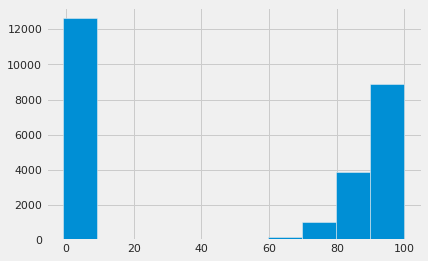

In [ ]:
ins.value_counts() ## this give a Series and counts each row as one unit

ins['score'].value_counts()
plt.hist(ins["score"])

In [ ]:
type(ins.value_counts())

pandas.core.series.Series

<br/><br/><br/>

---

## Question 3a

The column `iid` probably corresponds to an inspection id.  Is it a primary key?  Write an expression (line of code) that evaluates to `True` or `False` based on whether all the values are unique.

**Hint:** This is a very similar question to Question 1b.


<!--
BEGIN QUESTION
name: q3a
points: 1
-->

In [ ]:
is_ins_iid_a_primary_key = len(ins['iid'].unique()) == ins.shape[0]
is_ins_iid_a_primary_key

True

<br/><br/><br/>

---

## Question 3b

Later in this HW, we're going to merge the `bid` and `ins` DataFrames. To do this, we'll need to extract the `bid` from each row. If we look carefully, the column `iid` of the `ins` DataFrame appears to be the composition of two numbers and the first number looks like a business id.  

**Part 1.**: Create a new column called `bid` in the `ins` dataframe containing just the business id.  You will want to use `ins['iid'].str` operations to do this.  Also be sure to convert the type of this column to `int`. Hint: Similar to the early problem where we used `astype(string)` to convert a column to a String, here you should use `astype(int)` to convert the `bid` column into type int.

Optional: Write code which computes the number of `bid` values in `ins` which do not appear in `bus`. In other words, do we have any inspection results for restaurants which do not appear in our business dataset? If so, how many?

**No python `for` loops or list comprehensions are allowed, even for the optional problem.** This is on the honor system since our autograder isn't smart enough to check, but if you're using `for` loops or list comprehensions, you're doing the HW incorrectly.

**Part 1**

<!--
BEGIN QUESTION
name: q3bi
points: 2
-->

In [ ]:
bus.head()

,bid,name,address,city,state,postal_code,latitude,longitude,phone_number,postal5
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999,None
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284,None
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839,None
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315,None
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675,None


In [ ]:
ins.head()

,iid,date,score,type
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup


In [ ]:
ins['bid'] = ins['iid'].str.split("_", expand=True)[0].astype(int) #expand = True places the new strings into df columns vice a series with listsa
ins

,iid,date,score,type,bid
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017
...,...,...,...,...,...
26658,999_20180924,09/24/2018 12:00:00 AM,-1,Routine - Scheduled,999
26659,999_20181102,11/02/2018 12:00:00 AM,-1,Reinspection/Followup,999
26660,999_20190909,09/09/2019 12:00:00 AM,80,Routine - Unscheduled,999
26661,99_20171207,12/07/2017 12:00:00 AM,82,Routine - Unscheduled,99


In [ ]:
ins.dtypes

iid      object
date     object
score     int64
type     object
bid       int64
dtype: object

In [ ]:
ins[~ins['bid'].isin(bus['bid'])]  # all bid's in ins are in bus

,iid,date,score,type,bid


In [ ]:
len(ins['bid'].unique()) == len(bus['bid'].unique())

True

<br/><br/><br/>

---

## Question 3c

For this part, we're going to explore some new somewhat strange syntax that we haven't seen in lecture. Don't panic! If you're not sure what to do, try experimenting, Googling, and don't shy away from talking to other students or course staff.

For this problem we'll use the time component of the inspection data.  All of this information is given in the `date` column of the `ins` dataframe.

**Part 1:** What is the type of the individual `ins['date']` entries? You may want to grab the very first entry and use the `type` function in python.

**Part 2:** Rather than the type you discovered in Part 1, we want each entry in `pd.TimeStamp` format. You might expect that the usual way to convert something from it current type to `TimeStamp` would be to use `astype`. You can do that, but the more typical way is to use `pd.to_datetime`. Using `pd.to_datetime`, create a new `ins['timestamp']` column containing `pd.Timestamp` objects.  These will allow us to do date manipulation with much greater ease in part 3 and part 4

**Part 3:** What are the earliest and latest dates in our inspection data?  *Hint: you can use `min` and `max` on dates of the correct type.*

**Part 4:** We probably want to examine the inspections by year. Create an additional `ins['year']` column containing just the year of the inspection.  Consider using `pd.Series.dt.year` to do this.

In case you're curious, the documentation for `TimeStamp` data can be found at [this link](https://pandas.pydata.org/docs/reference/api/pandas.Timestamp.html#pandas.Timestamp).

**No python `for` loops or list comprehensions are allowed!**

**Part 1**

<!--
BEGIN QUESTION
name: q3ci
points: 1
-->

In [ ]:
ins_date_type = type(ins['date'][0])
ins_date_type

str

In [ ]:
ins.dtypes

iid      object
date     object
score     int64
type     object
bid       int64
dtype: object

**Part 2**

<!--
BEGIN QUESTION
name: q3cii
points: 1
-->

In [ ]:
ins['timestamp'] = pd.to_datetime(ins['date'])
ins

,iid,date,score,type,bid,timestamp
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010,2019-03-29
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017,2019-04-17
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017,2019-08-26
...,...,...,...,...,...,...
26658,999_20180924,09/24/2018 12:00:00 AM,-1,Routine - Scheduled,999,2018-09-24
26659,999_20181102,11/02/2018 12:00:00 AM,-1,Reinspection/Followup,999,2018-11-02
26660,999_20190909,09/09/2019 12:00:00 AM,80,Routine - Unscheduled,999,2019-09-09
26661,99_20171207,12/07/2017 12:00:00 AM,82,Routine - Unscheduled,99,2017-12-07


**Part 3**

<!--
BEGIN QUESTION
name: q3ciii
points: 1
-->

In [ ]:
earliest_date = min(ins['timestamp'])
latest_date = ins['timestamp'].max()

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

Earliest Date: 2016-10-04 00:00:00
Latest Date: 2019-11-28 00:00:00


**Part 4**

<!--
BEGIN QUESTION
name: q3civ
points: 1
-->

In [ ]:
ins['year'] = pd.DatetimeIndex(ins['timestamp']).year #note this worked with the str in ins['date']!

#or
ins['year'] = ins['timestamp'].dt.year
ins.sample(10)


,iid,date,score,type,bid,timestamp,year
14866,7757_20190829,08/29/2019 12:00:00 AM,94,Routine - Unscheduled,7757,2019-08-29,2019
21652,90758_20170519,05/19/2017 12:00:00 AM,-1,New Construction,90758,2017-05-19,2017
3502,2764_20180316,03/16/2018 12:00:00 AM,-1,Complaint,2764,2018-03-16,2018
20571,89449_20190918,09/18/2019 12:00:00 AM,-1,Complaint Reinspection/Followup,89449,2019-09-18,2019
18082,84888_20181022,10/22/2018 12:00:00 AM,-1,Reinspection/Followup,84888,2018-10-22,2018
2688,2252_20171215,12/15/2017 12:00:00 AM,84,Routine - Unscheduled,2252,2017-12-15,2017
11263,67063_20170705,07/05/2017 12:00:00 AM,72,Routine - Unscheduled,67063,2017-07-05,2017
16380,81161_20161017,10/17/2016 12:00:00 AM,90,Routine - Unscheduled,81161,2016-10-17,2016
10531,65137_20170802,08/02/2017 12:00:00 AM,81,Routine - Unscheduled,65137,2017-08-02,2017
19091,86765_20170210,02/10/2017 12:00:00 AM,-1,Reinspection/Followup,86765,2017-02-10,2017


In [ ]:
ins.head()

,iid,date,score,type,bid,timestamp,year
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010,2019-03-29,2019
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017,2019-04-17,2019
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017,2019-08-26,2019


<br/><br/><br/>

---

## Question 3d

Let's examine the inspection scores `ins['score']`



In [ ]:
ins['score'].value_counts().head()

-1      12632
 100     1993
 96      1681
 92      1260
 94      1250
Name: score, dtype: int64

There are a large number of inspections with the `'score'` of `-1`.   These are probably missing values.  Let's see what type of inspections have scores and which do not. Create the following dataframe, and assign it to to the variable `ins_missing_score_pivot`. You'll want to use the `pivot_table` method of the DataFrame class, which you can read about in the [pivot_table documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot_table.html).

You should observe that inspection scores appear only to be assigned to `Routine - Unscheduled` inspections.


<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>Missing Score</th>      <th>False</th>      <th>True</th>      <th>Total</th>    </tr>    <tr>      <th>type</th>      <th></th>      <th></th>      <th></th>    </tr>  </thead>  <tbody>    <tr>      <th>Routine - Unscheduled</th>      <td>14031</td>      <td>46</td>      <td>14077</td>    </tr>    <tr>      <th>Reinspection/Followup</th>      <td>0</td>      <td>6439</td>      <td>6439</td>    </tr>    <tr>      <th>New Ownership</th>      <td>0</td>      <td>1592</td>      <td>1592</td>    </tr>    <tr>      <th>Complaint</th>      <td>0</td>      <td>1458</td>      <td>1458</td>    </tr>    <tr>      <th>New Construction</th>      <td>0</td>      <td>994</td>      <td>994</td>    </tr>    <tr>      <th>Non-inspection site visit</th>      <td>0</td>      <td>811</td>      <td>811</td>    </tr>    <tr>      <th>New Ownership - Followup</th>      <td>0</td>      <td>499</td>      <td>499</td>    </tr>    <tr>      <th>Structural Inspection</th>      <td>0</td>      <td>394</td>      <td>394</td>    </tr>    <tr>      <th>Complaint Reinspection/Followup</th>      <td>0</td>      <td>227</td>      <td>227</td>    </tr>    <tr>      <th>Foodborne Illness Investigation</th>      <td>0</td>      <td>115</td>      <td>115</td>    </tr>    <tr>      <th>Routine - Scheduled</th>      <td>0</td>      <td>46</td>      <td>46</td>    </tr>    <tr>      <th>Administrative or Document Review</th>      <td>0</td>      <td>4</td>      <td>4</td>    </tr>    <tr>      <th>Multi-agency Investigation</th>      <td>0</td>      <td>3</td>      <td>3</td>    </tr>    <tr>      <th>Special Event</th>      <td>0</td>      <td>3</td>      <td>3</td>    </tr>    <tr>      <th>Community Health Assessment</th>      <td>0</td>      <td>1</td>      <td>1</td>    </tr>  </tbody></table>

Note that we create a "Missing Score" column, which will be `"True"` for inspections with a missing score, and `"False"` for those with a proper score. This column may be helpful, but you don't need to use it if you don't want to.

In [ ]:
type(ins)

pandas.core.frame.DataFrame

In [ ]:
ins['Missing Score'] = (ins['score'] == -1).astype("str")
ins

,iid,date,score,type,bid,timestamp,year,Missing Score
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction,100010,2019-03-29,2019,True
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019,False
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership,100017,2019-04-17,2019,True
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019,False
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup,100017,2019-08-26,2019,True
...,...,...,...,...,...,...,...,...
26658,999_20180924,09/24/2018 12:00:00 AM,-1,Routine - Scheduled,999,2018-09-24,2018,True
26659,999_20181102,11/02/2018 12:00:00 AM,-1,Reinspection/Followup,999,2018-11-02,2018,True
26660,999_20190909,09/09/2019 12:00:00 AM,80,Routine - Unscheduled,999,2019-09-09,2019,False
26661,99_20171207,12/07/2017 12:00:00 AM,82,Routine - Unscheduled,99,2017-12-07,2017,False


In [ ]:
bill = ins.pivot_table(
     index='type',     # rows (turned into index)
     columns='Missing Score',    # column values
     values=['score'], # field(s) to process in each group
     aggfunc=['count'],
     fill_value=0   # group operation
)#.sort_values(by=('score', 'False'), ascending=False)

bill

count      
                                   score      
Missing Score                      False  True
type                                          
Administrative or Document Review      0     4
Community Health Assessment            0     1
Complaint                              0  1458
Complaint Reinspection/Followup        0   227
Foodborne Illness Investigation        0   115
Multi-agency Investigation             0     3
New Construction                       0   994
New Ownership                          0  1592
New Ownership - Followup               0   499
Non-inspection site visit              0   811
Reinspection/Followup                  0  6439
Routine - Scheduled                    0    46
Routine - Unscheduled              14031    46
Special Event                          0     3
Structural Inspection                  0   394

In [ ]:
bill.columns

MultiIndex([('count', 'score', 'False'),
            ('count', 'score',  'True')],
           names=[None, None, 'Missing Score'])

In [ ]:
bill.columns = (["false", "true"])
bill.head(2)

,false,true
type,,
Administrative or Document Review,0,4
Community Health Assessment,0,1


In [ ]:
bill['Total'] = bill['false'] + bill['true']
bill.sort_values(by='Total', ascending = False)

,false,true,Total
type,,,
Routine - Unscheduled,14031,46,14077
Reinspection/Followup,0,6439,6439
New Ownership,0,1592,1592
Complaint,0,1458,1458
New Construction,0,994,994
Non-inspection site visit,0,811,811
New Ownership - Followup,0,499,499
Structural Inspection,0,394,394
Complaint Reinspection/Followup,0,227,227


In [ ]:

ins_missing_score_pivot = bill.sort_values(by='Total', ascending = False)

Notice that inspection scores appear only to be assigned to `Routine - Unscheduled` inspections. It is reasonable that for inspection types such as `New Ownership` and `Complaint` to have no associated inspection scores, but we might be curious why there are no inspection scores for the `Reinspection/Followup` inspection type.

<br/><br/><br/>

---

<br/><br/><br/>

# 4: Joining Data Across Tables

In this question we will start to connect data across mulitple tables.  We will be using the `merge` function.

<br/><br/><br/>

---

## Question 4a

Let's figure out which restaurants had the lowest scores. Before we proceed, let's filter out missing scores from `ins` so that negative scores don't influence our results.

Note that there might be something interesting we could learn from businesses with missing scores, but we are omitting such analysis from this HW. You might consider exploring this for the optional question at the end. Note: We have no idea if there is actually anything interesting to learn as we have not attempted this ourselves.

In [ ]:
ins = ins[ins["score"] > 0]
ins

,iid,date,score,type,bid,timestamp,year,Missing Score
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019,False
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019,False
15,100041_20190520,05/20/2019 12:00:00 AM,83,Routine - Unscheduled,100041,2019-05-20,2019,False
20,100055_20190425,04/25/2019 12:00:00 AM,98,Routine - Unscheduled,100055,2019-04-25,2019,False
21,100055_20190912,09/12/2019 12:00:00 AM,82,Routine - Unscheduled,100055,2019-09-12,2019,False
...,...,...,...,...,...,...,...,...
26654,999_20170714,07/14/2017 12:00:00 AM,77,Routine - Unscheduled,999,2017-07-14,2017,False
26656,999_20180123,01/23/2018 12:00:00 AM,80,Routine - Unscheduled,999,2018-01-23,2018,False
26660,999_20190909,09/09/2019 12:00:00 AM,80,Routine - Unscheduled,999,2019-09-09,2019,False
26661,99_20171207,12/07/2017 12:00:00 AM,82,Routine - Unscheduled,99,2017-12-07,2017,False


In [ ]:
bus

,bid,name,address,city,state,postal_code,latitude,longitude,phone_number,postal5
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999,None
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284,None
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839,None
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315,None
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675,None
...,...,...,...,...,...,...,...,...,...,...
6248,99948,SUSIECAKES BAKERY,3509 CALIFORNIA ST,San Francisco,CA,94118,-9999.000000,-9999.000000,14150452253,None
6249,99988,HINODEYA SOMA,303 02nd ST STE 102,San Francisco,CA,94107,-9999.000000,-9999.000000,-9999,None
6250,99991,TON TON,422 GEARY ST,San Francisco,CA,94102,-9999.000000,-9999.000000,14155531280,None
6251,99992,URBAN EXPRESS KITCHENS LLC,475 06th ST,San Francisco,CA,94103,-9999.000000,-9999.000000,14150368085,None


We'll start by creating a new dataframe called `ins_named`. It should be exactly the same as `ins`, except that it should have the name and address of every business, as determined by the `bus` dataframe. If a `business_id` in `ins` does not exist in `bus`, the name and address should be given as `NaN`.

*Hint*: Use the merge method to join the `ins` dataframe with the appropriate portion of the `bus` dataframe. See the official [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) on how to use `merge`.

*Note*: For quick reference, a pandas 'left' join keeps the keys from the left frame, so if `ins` is the left frame, all the keys from `ins` are kept and if a set of these keys don't have matches in the other frame, the columns from the other frame for these "unmatched" key rows contains NaNs.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [ ]:
ins_named = pd.merge(left = ins, right= bus[['bid', 'name', 'address']], on="bid", how='left')


...
display(ins_named.sample(10))
display(ins_named.shape)

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
11149,87648_20161202,12/02/2016 12:00:00 AM,94,Routine - Unscheduled,87648,2016-12-02,2016,False,Fly Bar-Divisadero,762 Divisadero St
8573,77760_20190326,03/26/2019 12:00:00 AM,82,Routine - Unscheduled,77760,2019-03-26,2019,False,"Plentea, Inc.",341 Kearny St
2459,33916_20190829,08/29/2019 12:00:00 AM,82,Routine - Unscheduled,33916,2019-08-29,2019,False,Extreme Pizza,1062 Folsom St
13593,96529_20190815,08/15/2019 12:00:00 AM,81,Routine - Unscheduled,96529,2019-08-15,2019,False,HARVEST WHEATFIELD BAKERY,431 CLEMENT ST
14030,99_20180808,08/08/2018 12:00:00 AM,84,Routine - Unscheduled,99,2018-08-08,2018,False,J & M A-1 CAFE RESTAURANT LLC,779 Clay St
8544,77682_20171215,12/15/2017 12:00:00 AM,100,Routine - Unscheduled,77682,2017-12-15,2017,False,T-WE TEA,50 Post St #12
1164,20367_20171117,11/17/2017 12:00:00 AM,76,Routine - Unscheduled,20367,2017-11-17,2017,False,Manila Oriental Market,4175 MISSION St
12304,91459_20180424,04/24/2018 12:00:00 AM,82,Routine - Unscheduled,91459,2018-04-24,2018,False,Kui Shin Bo #2,1424 Lombard St
3442,39888_20170425,04/25/2017 12:00:00 AM,96,Routine - Unscheduled,39888,2017-04-25,2017,False,Henry's Hunan Restaurant,1708 CHURCH St
9081,798_20180523,05/23/2018 12:00:00 AM,96,Routine - Unscheduled,798,2018-05-23,2018,False,Sushi Rapture,1400 Leavenworth St


(14031, 10)

In [ ]:
ins_named[pd.isnull(ins_named['name'])]

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address


In [ ]:
ins_named['name'].value_counts().tail(20)
#plt.hist(ins_named['name']) hist too big

Kissa Ko                                     1
ACE WASABI'S ROCK N ROLL SUSHI               1
La Mar Cebicheria Peruana                    1
Save More Market                             1
Jenny's Burger                               1
Pauline's Pizza                              1
Nick's Crispy Tacos                          1
Punch Line San Francisco                     1
Wing On Poultry, Inc                         1
KBGC, Inc.                                   1
Island Market & Deli                         1
Bon Appetit Management Company @ Yahoo SF    1
San Pancho's Tacos                           1
Cod Mother, Inc                              1
Hotel Drisco                                 1
El Antigua Cafe Corporation                  1
Berber Group, LLC                            1
Tanguito                                     1
United Nations Cafe                          1
ILLY CAFFE SF_PIER 39                        1
Name: name, dtype: int64

In [ ]:
#Example from the Pandas documentation

left = pd.DataFrame(
    {
        "key1": ["K0", "K0", "K1", "K2"],
        "key2": ["K0", "K1", "K0", "K1"],
        "A": ["A0", "A1", "A2", "A3"],
        "B": ["B0", "B1", "B2", "B3"],
    }
)


right = pd.DataFrame(
    {
        "key1": ["K0", "K1", "K1", "K2"],
        "key2": ["K0", "K0", "K0", "K0"],
        "C": ["C0", "C1", "C2", "C3"],
        "D": ["D0", "D1", "D2", "D3"],
    }
)


result = pd.merge(left, right, on=["key1", "key2"], how="left" )
display(left)
display(right)
display(result)

,key1,key2,A,B
0,K0,K0,A0,B0
1,K0,K1,A1,B1
2,K1,K0,A2,B2
3,K2,K1,A3,B3


,key1,key2,C,D
0,K0,K0,C0,D0
1,K1,K0,C1,D1
2,K1,K0,C2,D2
3,K2,K0,C3,D3


,key1,key2,A,B,C,D
0,K0,K0,A0,B0,C0,D0
1,K0,K1,A1,B1,NaN,NaN
2,K1,K0,A2,B2,C1,D1
3,K1,K0,A2,B2,C2,D2
4,K2,K1,A3,B3,NaN,NaN


<br/><br/><br/>

---

## Question 4b

Let's look at the 20 businesses with the lowest **median** score.  Order your results by the median score followed by the business name to break ties. The resulting table should look like the table below.

This one is pretty challenging! Don't forget to rename the score column. Hint: The agg function can accept a dictionary as an input. See the [agg documentation](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html).

As usual, **YOU SHOULD NOT USE LOOPS OR LIST COMPREHENSIONS**. Instead you should be cleverly chaining together different pandas functions.

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th>bid</th>      <th>name</th>      <th>median score</th>    </tr>  </thead>  <tbody>    <tr>      <th>84590</th>      <td>Chaat Corner</td>      <td>54.0</td>    </tr>    <tr>        <th>90622</th>      <td>Taqueria Lolita</td>      <td>57.0</td>    </tr>    <tr>         <th>94351</th>      <td>VBowls LLC</td>      <td>58.0</td>    </tr>    <tr>          <th>69282</th>      <td>New Jumbo Seafood Restaurant</td>      <td>60.5</td>    </tr>    <tr>         <th>1154</th>      <td>SUNFLOWER RESTAURANT</td>      <td>63.5</td>    </tr>  <tr>          <th>93150</th>      <td>Chez Beesen</td>      <td>64.0</td>    </tr>   <tr>     <th>39776</th>      <td>Duc Loi Supermarket</td>      <td>64.0</td>    </tr>  <tr>         <th>78328</th>      <td>Golden Wok</td>      <td>64.0</td>    </tr>  <tr>          <th>69397</th>      <td>Minna SF Group LLC</td>      <td>64.0</td>    </tr>     <tr>        <th>93502</th>      <td>Smoky Man</td>      <td>64.0</td>    </tr>    <tr>           <th>98995</th>      <td>Vallarta's Taco Bar</td>      <td>64.0</td>    </tr>    <tr>         <th>10877</th>      <td>CHINA FIRST INC.</td>      <td>64.5</td>    </tr>    <tr>        <th>71310</th>      <td>Golden King Vietnamese Restaurant</td>      <td>64.5</td>    </tr>     <tr>          <th>89070</th>      <td>Lafayette Coffee Shop</td>      <td>64.5</td>    </tr>
    <tr>          <th>71008</th>      <td>House of Pancakes</td>      <td>65.0</td>    </tr> <tr>         <th>2542</th>      <td>PETER D'S RESTAURANT</td>      <td>65.0</td>    </tr>            <tr>        <th>3862</th>      <td>IMPERIAL GARDEN SEAFOOD RESTAURANT</td>      <td>66.0</td>    </tr>    <tr>         <th>61427</th>      <td>Nick's Foods</td>      <td>66.0</td>    </tr>    <tr>          <th>72176</th>      <td>Wolfes Lunch</td>      <td>66.0</td>    </tr>    <tr>        <th>89141</th>      <td>Cha Cha Cha on Mission</td>      <td>66.5</td>    </tr>  </tbody></table>

In [ ]:
ins_named.groupby(["name"]).agg(np.median).sort_values(by=["score","name"]).head(20)

,score,bid,year
name,,,
Chaat Corner,54.0,84590.0,2018.0
Taqueria Lolita,57.0,90622.0,2018.0
VBowls LLC,58.0,94351.0,2019.0
New Jumbo Seafood Restaurant,60.5,69282.0,2018.5
SUNFLOWER RESTAURANT,63.5,1154.0,2018.5
Chez Beesen,64.0,93150.0,2018.0
Duc Loi Supermarket,64.0,39776.0,2018.5
Golden Wok,64.0,78328.0,2019.0
Minna SF Group LLC,64.0,69397.0,2017.0


In [ ]:
twenty_lowest_scoring = ins_named.groupby(["name"]).agg(np.median).sort_values(by=["score","name"]).head(20)

# DO NOT USE LIST COMPREHENSIONS OR LOOPS OF ANY KIND!!!

...

twenty_lowest_scoring.drop(columns = ['bid','year']) #pd.drop DEFAULTS to rows...axis=0!!!!)

,score
name,
Chaat Corner,54.0
Taqueria Lolita,57.0
VBowls LLC,58.0
New Jumbo Seafood Restaurant,60.5
SUNFLOWER RESTAURANT,63.5
Chez Beesen,64.0
Duc Loi Supermarket,64.0
Golden Wok,64.0
Minna SF Group LLC,64.0


### Question 4c

Let's figure out which restaurant had the worst score ever (single lowest score).

In the cell below, assign `worst_restaurant` to the name of the restaurant with the **lowest inspection score ever**. For fun: Look up the reviews for this restaurant on yelp. Do you see any reviews that indicate this restaurant had health inspection issues?

<!--
BEGIN QUESTION
name: q4c
points: 2
-->

In [ ]:
ins_named

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
0,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled,100010,2019-04-03,2019,False,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B
1,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled,100017,2019-08-16,2019,False,AMICI'S EAST COAST PIZZERIA,475 06th St
2,100041_20190520,05/20/2019 12:00:00 AM,83,Routine - Unscheduled,100041,2019-05-20,2019,False,UNCLE LEE CAFE,3608 BALBOA ST
3,100055_20190425,04/25/2019 12:00:00 AM,98,Routine - Unscheduled,100055,2019-04-25,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr
4,100055_20190912,09/12/2019 12:00:00 AM,82,Routine - Unscheduled,100055,2019-09-12,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr
...,...,...,...,...,...,...,...,...,...,...
14026,999_20170714,07/14/2017 12:00:00 AM,77,Routine - Unscheduled,999,2017-07-14,2017,False,SERRANO'S PIZZA II,3274 21st St
14027,999_20180123,01/23/2018 12:00:00 AM,80,Routine - Unscheduled,999,2018-01-23,2018,False,SERRANO'S PIZZA II,3274 21st St
14028,999_20190909,09/09/2019 12:00:00 AM,80,Routine - Unscheduled,999,2019-09-09,2019,False,SERRANO'S PIZZA II,3274 21st St
14029,99_20171207,12/07/2017 12:00:00 AM,82,Routine - Unscheduled,99,2017-12-07,2017,False,J & M A-1 CAFE RESTAURANT LLC,779 Clay St


In [ ]:
worst_restaurant = ins_named.sort_values(by='score').head(1)['name']
worst_restaurant

10898    Lollipot
Name: name, dtype: object

Did this restaurant clean up its act? Look in the database to see if it passed its next inspection.

> Indented block



In [ ]:
# perfrom a query to tell whether or not this restaurant
# had a better score during its next inspection.
#
# this exercise is not graded.

ins_named.query('name == "Lollipot"')
ins_named.query('name in @worst_restaurant')
## this doesn't work:  ins_named.query('name == worst_restaurant')


,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
10897,86718_20161116,11/16/2016 12:00:00 AM,90,Routine - Unscheduled,86718,2016-11-16,2016,False,Lollipot,890 Taraval St
10898,86718_20180522,05/22/2018 12:00:00 AM,45,Routine - Unscheduled,86718,2018-05-22,2018,False,Lollipot,890 Taraval St
10899,86718_20181005,10/05/2018 12:00:00 AM,90,Routine - Unscheduled,86718,2018-10-05,2018,False,Lollipot,890 Taraval St


<br/><br/><br/><br/>

---

<br/><br/>

## 5: Explore Inspection Scores

In this part we explore some of the basic inspection score values visually.

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---


## Question 5a
Let's look at the distribution of inspection scores. As we saw before when we called head on this data frame, inspection scores appear to be integer values. The discreteness of this variable means that we can use a bar plot to visualize the distribution of the inspection score. Make a bar plot of the counts of the number of inspections receiving each score.

It should look like the image below. It does not need to look exactly the same (e.g., no grid), but **make sure that all labels and axes are correct**.

You should use the `ins` dataframe, and should ignore any score that is less than 0.

![](pics/6a.png)

You might find this [matplotlib.pyplot tutorial](https://matplotlib.org/tutorials/introductory/pyplot.html) useful. Key syntax that you'll need:

```
plt.bar
plt.xlabel
plt.ylabel
plt.title
```

To set the color of the edges for your bars, include `edgecolor = 'black'.

<!--
BEGIN QUESTION
name: q5a
points: 1
manual: True
-->

In [ ]:
...

Ellipsis

<!-- END QUESTION -->



We can also generate a similar figure using the plotly library. I (Josh) **love** plotly. It provides an extremely rich library for visualizing DataFrames, and the syntax is very user friendly.

Note that the figure that plotly generates is interactive: You can hover over bars and get back values of interest.

In [ ]:
import plotly.express as px
px.histogram(ins, x = "score")

The figure above has a bin size of 1.

Often, when plotting a histogram, we bin observations into wider bins. Try generating a histogram with 20 bins.

The documentation you'll need can be found at [https://plotly.com/python/histograms/](https://plotly.com/python/histograms/).

This plot will not be graded.

In [ ]:
import plotly.express as px
...

<!-- BEGIN QUESTION -->

<br/><br/><br/>

---

### Question 5b

Now let's actaully reflect on the histogram that we generated before with a bin size of 1.

Describe the qualities of the distribution of the inspections scores based on your bar plot. Consider the mode(s), symmetry, tails, gaps, and anomalous values. Are there any unusual features of this distribution? What do your observations imply about the scores?

<!--
BEGIN QUESTION
name: q5b
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



<br/><br/><br/><br/>

---

<br/><br/>

## 6: Restaurant Ratings Over Time

Let's consider various scenarios involving restaurants with multiple ratings over time.



<br/><br/><br/>

---

### Question 6a

As a somewhat contrived exercise in data manipulation, let's see which restaurant location has had the most extreme improvement in its scores. Let the "swing" of a restaurant location be defined as the difference between its highest-ever and lowest-ever score. **Only consider restaurant locations with at least 3 scores—that is, restaurants that were rated at least 3 times.** Using whatever technique you want to use, assign `max_swing` to the name of restaurant that has the maximum swing.

*Note*: The "swing" is of a specific restaurant locations. There might be some restaurants with multiple locations; each location has its own "swing".

<!--
BEGIN QUESTION
name: q6a
points: 3
-->

In [ ]:
#get list of names with 3 or more value_counts in ins_named
names_ge3 = ins_named['name'].value_counts()[ins_named['name'].value_counts() >= 3]
names_ge3
names_ge3.index
#type(names_ge3)


Index(['Peet's Coffee & Tea', 'Starbucks Coffee', 'McDonald's', 'Jamba Juice',
       'Proper Food', 'STARBUCKS', 'Mixt Greens/Mixt', 'The Organic Coup',
       'Specialty's Cafe & Bakery', 'Bon Appetit @ Twitter',
       ...
       'Covo', 'Great Gold Restaurant', 'CAFE-ROSSO',
       'Valencia WholeFoods Inc', 'LA MEJOR BAKERY',
       '260 Golden Gate Family Residence', 'POPEYES-GENEVA & MISSION',
       'Corridor', 'Mendelsohn House', 'Eva's Catering'],
      dtype='object', length=2552)

In [ ]:
# filter ins_named for just those in the names_ge3 Series
ins_ge3 = ins_named[ins_named['name'].isin(names_ge3.index)]
ins_ge3

,iid,date,score,type,bid,timestamp,year,Missing Score,name,address
3,100055_20190425,04/25/2019 12:00:00 AM,98,Routine - Unscheduled,100055,2019-04-25,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr
4,100055_20190912,09/12/2019 12:00:00 AM,82,Routine - Unscheduled,100055,2019-09-12,2019,False,Twirl and Dip,335 Martin Luther King Jr. Dr
9,100079_20190827,08/27/2019 12:00:00 AM,98,Routine - Unscheduled,100079,2019-08-27,2019,False,POSITIVE FOODS,475 06TH ST
16,1000_20171002,10/02/2017 12:00:00 AM,74,Routine - Unscheduled,1000,2017-10-02,2017,False,HEUNG YUEN RESTAURANT,3279 22nd St
17,1000_20180523,05/23/2018 12:00:00 AM,76,Routine - Unscheduled,1000,2018-05-23,2018,False,HEUNG YUEN RESTAURANT,3279 22nd St
...,...,...,...,...,...,...,...,...,...,...
13980,9948_20190204,02/04/2019 12:00:00 AM,80,Routine - Unscheduled,9948,2019-02-04,2019,False,Whole Foods Market,399 04th St
13981,9948_20190830,08/30/2019 12:00:00 AM,88,Routine - Unscheduled,9948,2019-08-30,2019,False,Whole Foods Market,399 04th St
14026,999_20170714,07/14/2017 12:00:00 AM,77,Routine - Unscheduled,999,2017-07-14,2017,False,SERRANO'S PIZZA II,3274 21st St
14027,999_20180123,01/23/2018 12:00:00 AM,80,Routine - Unscheduled,999,2018-01-23,2018,False,SERRANO'S PIZZA II,3274 21st St


In [ ]:
ins_ge3.groupby('name')['score'].max()
ins_ge3.groupby(['name'])['score'].min()


name
111 Minna Gallery         92
17th & Noe Market         96
18th Street Commissary    75
20 Spot Mission, LLC      88
21 Taste House            79
                          ..
Zita                      98
Zpizza                    92
Zynga                     92
Zzan                      65
iNoodles                  90
Name: score, Length: 2552, dtype: int64

In [ ]:
minmax = pd.merge(
    left=ins_ge3.groupby('name')['score'].max(),
    right=ins_ge3.groupby('name')['score'].min(),
    on='name')
minmax

,score_x,score_y
name,,
111 Minna Gallery,100,92
17th & Noe Market,96,96
18th Street Commissary,85,75
"20 Spot Mission, LLC",96,88
21 Taste House,96,79
...,...,...
Zita,100,98
Zpizza,94,92
Zynga,94,92


In [ ]:
minmax['diff'] = minmax['score_x'] - minmax['score_y']
minmax.sort_values(by='diff', ascending=False)

,score_x,score_y,diff
name,,,
Lollipot,90,45,45
Mi Tierra Market,93,57,36
Jersey,100,66,34
Wing Lee BBQ Restaurant,92,59,33
Howard & 6th Street Food Market Inc.,92,59,33
...,...,...,...
Farmers Market & Produce,92,92,0
SPIKE'S COFFEES & TEAS,100,100,0
Courtyard San Francisco Union Square,100,100,0


In [ ]:
...
max_swing = minmax.sort_values(by='diff', ascending=False).head(1)
max_swing = max_swing.index[0]
max_swing

'Lollipot'

<br/><br/><br/>

---


### Question 6b

The city would like to know if food safety inspections work. This is a pretty vague and broad question. Such of questions are common in the field of data science!

In part 6b and 6c we'll explore one possible way to explore this question just using the data we have available.

Specifically, we'll ask: What's the relationship between the first and second scores for the businesses with 2 inspections in a year? Do they typically improve? What can we say about restaurants that initially failed? For simplicity, let's focus on only 2018 for this problem, using the `ins2018` DataFrame that will be created for you below.

In the following cell, we create a DataFrame called `scores_pairs_by_business` indexed by `bid` (containing only businesses with exactly 2 inspections in 2018). This DataFrame contains the field score_pair consisting of the score pairs ordered chronologically: `[first_score, second_score]`.

In [ ]:
ins2018 = ins[ins['year'] == 2018]

two_score_businesses = (ins2018.sort_values('date')
                            .loc[:, ['bid', 'score']]
                            .groupby('bid')
                            .filter(lambda group: len(group)==2)
                       )

first_scores = two_score_businesses.groupby("bid").first()
second_scores = two_score_businesses.groupby("bid").last()

scores = pd.merge(first_scores, second_scores, on = "bid") \
                        .rename(columns = {"score_x": "first score",
                                           "score_y": "second score"})

scores

,first score,second score
bid,,
48,94,87
66,98,98
146,81,90
184,90,96
273,83,84
...,...,...
95621,100,100
95628,75,75
95674,100,96


In [ ]:
two_score_businesses.sort_values(by=["bid","score"])
first_scores


,score
bid,
48,94
66,98
146,81
184,90
273,83
...,...
95621,100
95628,75
95674,100


<!-- BEGIN QUESTION -->

Now let's make a scatter plot to display these pairs of scores. Include on the plot a reference line with slope 1 and y-intercept 0. Since restaurant scores bottom out at 45 points, we'll only focus on ratings between 45 and 100. Thus your reference line should start at `[45, 45]` and go up to `[100, 100].`

Create your scatter plot in the cell below. It does not need to look exactly the same (e.g., no grid) as the sample below, but make sure that all labels, axes and data itself are correct.

![](pics/7c.png)

Key pieces of syntax you'll need:

`plt.scatter` plots a set of points. Use `facecolors='none'` and `edgecolors='b'` to make circle markers with blue borders.

`plt.plot` for the reference line. Using the argument `r` will make the line red.

`plt.xlabel`, `plt.ylabel`, `plt.axis`, and `plt.title`.


<!--
BEGIN QUESTION
name: q6b
points: 2
manual: True
-->

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/><br/><br/>


---


### Question 6c

If restaurants' scores tend to improve from the first to the second inspection, what do you expect to see in the scatter plot that you made in question 6b? What do you oberve from the plot? Are your observations consistent with your expectations?

Hint: What does the slope represent?

<!--
BEGIN QUESTION
name: q6c
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



### Alternate View of Question 6b (optional)

The code below creates an alternate dataframe that shows the first and second scores in the same column of the dataframe, where each column is a list. This is a less common way to represent the same data as in part 6b.

This approach works by using `agg(list)` to combine each group into a list. Here `list` is the constructor for the python list class. It's clever!

In [ ]:
ins2018 = ins[ins['year'] == 2018]
scores_pairs_by_business = (ins2018.sort_values('date')
                            .loc[:, ['bid', 'score']]
                            .groupby('bid')
                            .filter(lambda group: len(group)==2)
                            .groupby('bid')
                            .agg(list)
                            .rename(columns={'score':'score_pair'}))
scores_pairs_by_business

,score_pair
bid,
48,"[94, 87]"
66,"[98, 98]"
146,"[81, 90]"
184,"[90, 96]"
273,"[83, 84]"
...,...
95621,"[100, 100]"
95628,"[75, 75]"
95674,"[100, 96]"


In case you're curious, the `explode` function exists to take list like columns and ... well, explode them! Basically doing the reverse of the process above.

In [ ]:
scores_pairs_by_business.explode('score_pair')

,score_pair
bid,
48,94
48,87
66,98
66,98
146,81
...,...
95674,96
95761,91
95761,87


Or if we wanted to convert a list like dataframe into a more normal dataframe with two columns, we could use the code below:

In [ ]:
pd.DataFrame(scores_pairs_by_business['score_pair'].to_list(),
             columns=['one', 'two'])

,one,two
0,94,87
1,98,98
2,81,90
3,90,96
4,83,84
...,...,...
530,100,100
531,75,75
532,100,96
533,91,87


## Summary of Inspections Data

We have done a lot in this homework! Below are some examples of what we have learned about the inspections data through some cool visualizations!

- We found that the records are at the inspection level and that we have inspections for multiple years.
- We also found that many restaurants have more than one inspection a year.
- By joining the business and inspection data, we identified the name of the restaurant with the worst rating.
- We identified the restaurant that had the largest swing in rating over time.
- We also examined the change of scores over time! Many restaurants are not actually doing better.

<br/><br/><br/><br/>

---

<br/><br/>

# 7: Open Ended Question [OPTIONAL]

### Discover something interesting about the data!

<br/>

Play with the data, and try to answer one question that you find interesting regarding the data. Show us how you would answer this question through exploratory data analysis.

Here are some possible routes you can take in completing your analysis:
* Construct a dataframe by computing something interesting about the data with methods such as `merge`/`groupby`/`pivot`, etc.
* Create a visualization with the data from which you can draw a conclusion that can answer you question.

Here are some possible questions you can ask about the data:
* How do the inspection scores relate to the geolocation (latitude, longitude) of a restaurant?
* How do all the inspection scores for each type of business change over time?

**Note**: You are not limited to the questions we provided above. We actually strongly recommend you to explore something you are personally interested in knowing about the data. On topics such as how the socioeconomic background of the neighborhoods impact all the nearby restaurants, you are welcome to reference external sources (make sure to cite the sources) as well to guide your exploration.

Please show your work in the cells below, feel free to use extra cells if you want.

**NOTE: This question is optional. It will not be graded. Just make sure any code you use here runs properly, as it might break the autograder if it errors.**

In [ ]:
# YOUR WORK HERE

## Congratulations! You have finished Homework 2! ##

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()